In [1]:
#Import all the libraries need for the analysis

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

## Case Study: Ensuring Election Integrity

In the recently concluded election, the Independent National Electoral Commission (INEC) has faced multiple legal challenges concerning the integrity and accuracy of the election results. Allegations of vote manipulation and irregularities have been widespread, prompting a thorough investigation into the matter.
Your mission, should you choose to accept it, is to help us uncover potential voting irregularities and ensure the transparency of the election results. You will achieve this by identifying outlier polling units where the voting results deviate significantly from neighbouring units, indicating potential influences or rigging. Your keen analytical skills and attention to detail will be critical in this endeavour.

### Task Overview

In this stage, you will focus on identifying outlier polling units based on the votes each party received. The analysis will involve geospatial techniques to find neighbouring polling units and calculate an outlier score for each party in each unit. The goal is to pinpoint polling units where the voting results significantly deviate from their neighbours, indicating potential irregularities or influences.


#### Data Preparation

We will proceed to import our dataset which contains a crosschecked list of all polling unit resuts for all the LGA in Anambra state. The coordinates for each polling unit has been manually added in excel but not all the polling unit coordinates are available. We would proceed to drop polling units without coordinates and proceed with our analysis. 

In [2]:
anambra = pd.read_csv('ANAMBRA_crosschecked.csv')

In [3]:
polling_units = pd.read_csv('polling-units.csv')

In [4]:
anambra.head()

,State,LGA,Ward,PU-Code,PU-Name,Accredited_Voters,Registered_Voters,Results_Found,Transcription_Count,Result_Sheet_Stamped,...,Result_Sheet_Invalid,Result_Sheet_Unclear,Result_Sheet_Unsigned,APC,LP,PDP,NNPP,Results_File,Lat,Long
0,ANAMBRA,AGUATA,ACHINA I,04-01-01-001,ST. CHARLE'S SCHOOL,171,630,True,-1,False,...,False,False,UNKNOWN,0,0,0,0,https://docs.inecelectionresults.net/elections...,5.968252,7.124711
1,ANAMBRA,AGUATA,ACHINA I,04-01-01-005,AMANKWU SQUARE,153,500,True,-1,False,...,False,False,UNKNOWN,3,142,0,1,https://docs.inecelectionresults.net/elections...,5.961565,7.103548
2,ANAMBRA,AGUATA,ACHINA I,04-01-01-006,COOPERATIVE HALL,121,386,True,-1,False,...,False,False,UNKNOWN,0,0,0,0,https://docs.inecelectionresults.net/elections...,5.961565,7.103548
3,ANAMBRA,AGUATA,ACHINA I,04-01-01-008,OCHIEOBU SQUARE,134,426,True,-1,False,...,False,False,UNKNOWN,0,124,4,1,https://docs.inecelectionresults.net/elections...,5.961565,7.103548
4,ANAMBRA,AGUATA,ACHINA I,04-01-01-010,OYE MOTOR PARK II,63,166,True,-1,False,...,False,False,UNKNOWN,4,57,0,0,https://docs.inecelectionresults.net/elections...,5.968252,7.124711


In [10]:
polling_units.head()

,name,ward_name,local_government_name,state_name,location.latitude,location.longitude
0,"LGEA SCHOOL INABE, INABE/EFOJA",OLAMABORO V,OLAMABORO,KOGI,7.178359,7.577163
1,"LGEA SCHOOL INELE, UGO I & II",OLAMABORO V,OLAMABORO,KOGI,43.469120,-80.575699
2,"UNOBE MKT. SQUARE, UNOBE",OLAMABORO V,OLAMABORO,KOGI,7.222232,7.565029
3,"LGEA SCHOOL UGOJOUALE, UGOJO UBALU",OLAMABORO V,OLAMABORO,KOGI,7.178359,7.577163
4,"OPEN SPACE, UKPOKIDO",OLAMABORO V,OLAMABORO,KOGI,7.222232,7.565029


In [15]:
anambra_coordinates = polling_units[polling_units['state_name'] == "ANAMBRA"]

In [16]:
anambra_coordinates

,name,ward_name,local_government_name,state_name,location.latitude,location.longitude
13056,ONITSHA BOYS HIGH SCHOOL I,OGBE UMUONICHA,ONITSHA-NORTH,ANAMBRA,6.134493,6.775860
13057,ONITSHA BOYS HIGH SCHOOL II,OGBE UMUONICHA,ONITSHA-NORTH,ANAMBRA,6.134493,6.775860
13058,ONITSHA BOYS HIGH SCHOOL III,OGBE UMUONICHA,ONITSHA-NORTH,ANAMBRA,6.134493,6.775860
13059,OBI ANAZONWU PRY. SCHOOL I,OGBE UMUONICHA,ONITSHA-NORTH,ANAMBRA,6.144261,6.793483
13060,OBI ANAZONWU PRY. SCHOOL II,OGBE UMUONICHA,ONITSHA-NORTH,ANAMBRA,6.144261,6.793483
...,...,...,...,...,...,...
18770,UDOKA P/S,AWKUZU I,OYI,ANAMBRA,6.224901,6.944878
18771,IRUAMA SQUARE,AWKUZU I,OYI,ANAMBRA,6.224901,6.944878
18772,AMA-OKOLO SQ,AWKUZU I,OYI,ANAMBRA,6.250657,6.937696
18773,AMAFOR VILLAGE SQ (OPEN SPACE),AWKUZU I,OYI,ANAMBRA,51.075915,-113.954025


In [25]:
anambra.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3679 entries, 0 to 3678
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   State                   3679 non-null   object 
 1   LGA                     3679 non-null   object 
 2   Ward                    3679 non-null   object 
 3   PU-Code                 3679 non-null   object 
 4   PU-Name                 3679 non-null   object 
 5   Accredited_Voters       3679 non-null   int64  
 6   Registered_Voters       3679 non-null   int64  
 7   Results_Found           3679 non-null   bool   
 8   Transcription_Count     3679 non-null   int64  
 9   Result_Sheet_Stamped    3679 non-null   bool   
 10  Result_Sheet_Corrected  3679 non-null   bool   
 11  Result_Sheet_Invalid    3679 non-null   bool   
 12  Result_Sheet_Unclear    3679 non-null   bool   
 13  Result_Sheet_Unsigned   3679 non-null   object 
 14  APC                     3679 non-null   

In [28]:
anambra.dropna(inplace = True)

In [29]:
anambra.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3614 entries, 0 to 3678
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   State                   3614 non-null   object 
 1   LGA                     3614 non-null   object 
 2   Ward                    3614 non-null   object 
 3   PU-Code                 3614 non-null   object 
 4   PU-Name                 3614 non-null   object 
 5   Accredited_Voters       3614 non-null   int64  
 6   Registered_Voters       3614 non-null   int64  
 7   Results_Found           3614 non-null   bool   
 8   Transcription_Count     3614 non-null   int64  
 9   Result_Sheet_Stamped    3614 non-null   bool   
 10  Result_Sheet_Corrected  3614 non-null   bool   
 11  Result_Sheet_Invalid    3614 non-null   bool   
 12  Result_Sheet_Unclear    3614 non-null   bool   
 13  Result_Sheet_Unsigned   3614 non-null   object 
 14  APC                     3614 non-null   

In [37]:
anambra.drop(columns=['State','Ward','Accredited_Voters','Registered_Voters','Results_Found','Transcription_Count','Result_Sheet_Stamped','Result_Sheet_Corrected','Result_Sheet_Invalid','Result_Sheet_Unclear','Result_Sheet_Unsigned','Results_File'], inplace=True)
anambra

,LGA,PU-Code,PU-Name,APC,LP,PDP,NNPP,Lat,Long
0,AGUATA,04-01-01-001,ST. CHARLE'S SCHOOL,0,0,0,0,5.968252,7.124711
1,AGUATA,04-01-01-005,AMANKWU SQUARE,3,142,0,1,5.961565,7.103548
2,AGUATA,04-01-01-006,COOPERATIVE HALL,0,0,0,0,5.961565,7.103548
3,AGUATA,04-01-01-008,OCHIEOBU SQUARE,0,124,4,1,5.961565,7.103548
4,AGUATA,04-01-01-010,OYE MOTOR PARK II,4,57,0,0,5.968252,7.124711
...,...,...,...,...,...,...,...,...,...
3673,AWKA SOUTH,04-07-19-027,NODU VILLAGE HALL VI (OPEN SPACE OPPOSITE NODU...,0,27,1,0,6.232478,7.070082
3674,AWKA SOUTH,04-07-19-028,NODU VILLAGE HALL VII (OPEN SPACE OPPOSITE NOD...,0,51,0,0,6.232478,7.070082
3675,AWKA SOUTH,04-07-19-029,NIGERIA UNION OF JOURNALISTS PREMISES (OPEN SP...,2,95,0,0,6.243888,7.060723
3676,AWKA SOUTH,04-07-19-030,OKOCHI VILLAGE HALL II,0,0,0,0,6.247326,7.061944


In [7]:
import pandas as pd
from geopy.distance import geodesic
import numpy as np

# Load the dataset
file_path = 'ANAMBRA_crosschecked.csv'
data = pd.read_csv(file_path)

# Remove rows with missing or invalid latitude and longitude values
cleaned_data = data.dropna(subset=['Lat', 'Long'])

# Check for any non-numeric values in Lat and Long columns
cleaned_data = cleaned_data[pd.to_numeric(cleaned_data['Lat'], errors='coerce').notnull()]
cleaned_data = cleaned_data[pd.to_numeric(cleaned_data['Long'], errors='coerce').notnull()]

# Ensure that the latitude and longitude columns are of type float
cleaned_data['Lat'] = cleaned_data['Lat'].astype(float)
cleaned_data['Long'] = cleaned_data['Long'].astype(float)

# Function to calculate the distance between two points (lat, long)
def calculate_distance(coord1, coord2):
    return geodesic(coord1, coord2).km

# Define the radius in kilometers
radius_km = 1

# Calculate distances and identify neighbors within each LGA
neighbors = {}

# Group the data by LGA
grouped_data = cleaned_data.groupby('LGA')

for lga, group in grouped_data:
    lga_neighbors = {}
    
    for i, row1 in group.iterrows():
        pu1 = row1['PU-Code']
        coord1 = (row1['Lat'], row1['Long'])
        lga_neighbors[pu1] = []
        
        for j, row2 in group.iterrows():
            if i != j:
                coord2 = (row2['Lat'], row2['Long'])
                distance = calculate_distance(coord1, coord2)
                if distance <= radius_km:
                    lga_neighbors[pu1].append(row2['PU-Code'])
    
    neighbors.update(lga_neighbors)

# Calculate outlier scores based on absolute difference
outlier_scores = []

# Create the vote columns based on the party votes
party_columns = ['APC', 'LP', 'PDP', 'NNPP']  # Update this list with actual party columns

for i, row in cleaned_data.iterrows():
    pu_code = row['PU-Code']
    neighbor_codes = neighbors.get(pu_code, [])
    
    if neighbor_codes:
        neighbor_data = cleaned_data[cleaned_data['PU-Code'].isin(neighbor_codes)]
        
        for party in party_columns:
            votes = row[party]
            avg_votes = neighbor_data[party].mean()
            absolute_difference = abs(votes - avg_votes)
            
            outlier_scores.append({
                'PU-Code': pu_code,
                'Party': party,
                'Votes': votes,
                'Avg_Votes': avg_votes,
                'Outlier_Score': absolute_difference,
                'Neighboring_PUs': neighbor_codes
            })

# Create a dataframe to store the results
outlier_scores_df = pd.DataFrame(outlier_scores)

# Sort the dataframe by Outlier_Score for each party and display the top outliers
sorted_outliers = outlier_scores_df.sort_values(by='Outlier_Score', ascending=False)

# Select the top 3 outliers
top_3_outliers = sorted_outliers.head(3)

# Display the top 3 outliers
print(top_3_outliers)

# Analyze and explain the top 3 outliers
for index, row in top_3_outliers.iterrows():
    print(f"Polling Unit: {row['PU-Code']}")
    print(f"Party: {row['Party']}")
    print(f"Votes: {row['Votes']}")
    print(f"Average Votes of Neighbors: {row['Avg_Votes']}")
    print(f"Outlier Score: {row['Outlier_Score']}")
    print(f"Neighboring Polling Units: {row['Neighboring_PUs']}")
    print(f"Explanation: The polling unit {row['PU-Code']} has a significantly different number of votes for {row['Party']} compared to its neighboring units, making it an outlier.")
    print("\n")


           PU-Code Party  Votes   Avg_Votes  Outlier_Score  \
1069  04-03-03-003    LP    526   48.333333     477.666667   
3318  04-06-11-007   PDP    465    5.666667     459.333333   
1077  04-03-03-005    LP    543  102.357143     440.642857   

                                        Neighboring_PUs  
1069         [04-03-07-008, 04-03-07-009, 04-03-08-007]  
3318  [04-06-11-001, 04-06-11-002, 04-06-11-004, 04-...  
1077  [04-03-03-004, 04-03-04-010, 04-03-04-011, 04-...  
Polling Unit: 04-03-03-003
Party: LP
Votes: 526
Average Votes of Neighbors: 48.333333333333336
Outlier Score: 477.6666666666667
Neighboring Polling Units: ['04-03-07-008', '04-03-07-009', '04-03-08-007']
Explanation: The polling unit 04-03-03-003 has a significantly different number of votes for LP compared to its neighboring units, making it an outlier.


Polling Unit: 04-06-11-007
Party: PDP
Votes: 465
Average Votes of Neighbors: 5.666666666666667
Outlier Score: 459.3333333333333
Neighboring Polling Units: ['04-

In [11]:
top_3_outliers

,PU-Code,Party,Votes,Avg_Votes,Outlier_Score,Neighboring_PUs
1069,04-03-03-003,LP,526,48.333333,477.666667,"[04-03-07-008, 04-03-07-009, 04-03-08-007]"
3318,04-06-11-007,PDP,465,5.666667,459.333333,"[04-06-11-001, 04-06-11-002, 04-06-11-004, 04-..."
1077,04-03-03-005,LP,543,102.357143,440.642857,"[04-03-03-004, 04-03-04-010, 04-03-04-011, 04-..."


In [10]:
sorted_outliers.to_csv('sorted_outliers.csv', index=False, encoding='utf-8')

In [9]:
top_3_outliers.to_excel('top_3_outliers.xlsx', index=False)

### Data Visualization

To visualize the output and show insights, we can use Python with libraries like Matplotlib and Seaborn. We will create the following visualizations:

Bar plot showing the outlier scores for each party in the top outlier polling units.
Scatter plot showing the relationship between the votes and average votes of neighboring units, highlighting the outliers.
Heatmap showing the distribution of outlier scores across the polling units.

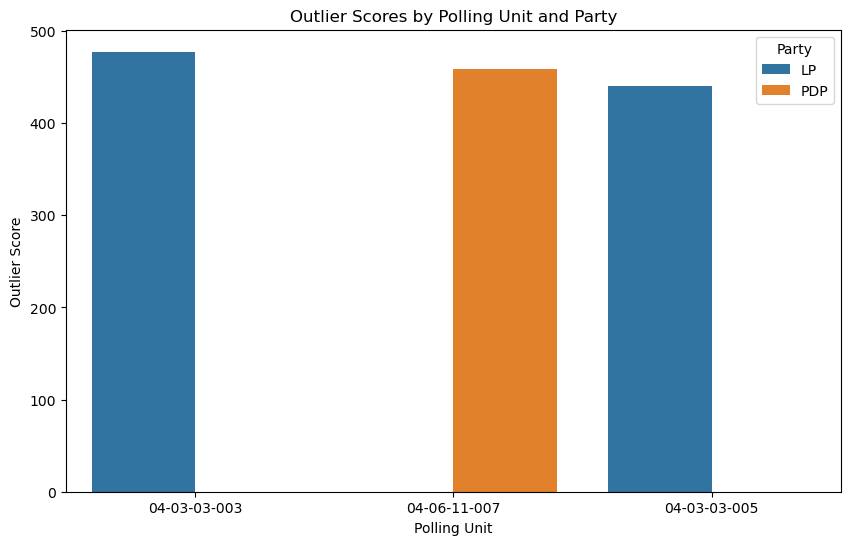

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns


df = top_3_outliers

# Bar plot of Outlier Scores
plt.figure(figsize=(10, 6))
sns.barplot(x='PU-Code', y='Outlier_Score', hue='Party', data=df)
plt.title('Outlier Scores by Polling Unit and Party')
plt.xlabel('Polling Unit')
plt.ylabel('Outlier Score')
plt.legend(title='Party')
plt.show()

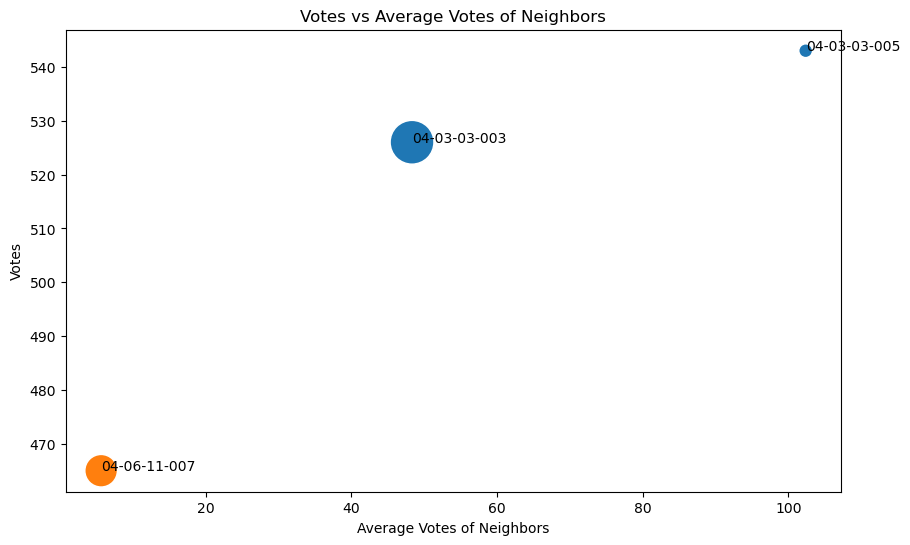

In [15]:
# Scatter plot of Votes vs Avg_Votes with Outlier Scores
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Avg_Votes', y='Votes', size='Outlier_Score', hue='Party', data=df, sizes=(100, 1000), legend=False)
for index, row in df.iterrows():
    plt.text(row['Avg_Votes'], row['Votes'], row['PU-Code'])
plt.title('Votes vs Average Votes of Neighbors')
plt.xlabel('Average Votes of Neighbors')
plt.ylabel('Votes')
plt.show()

C:\Users\Henry Okam\AppData\Local\Temp\ipykernel_8464\2608979547.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  pivot_df = df.pivot("PU-Code", "Party", "Outlier_Score")


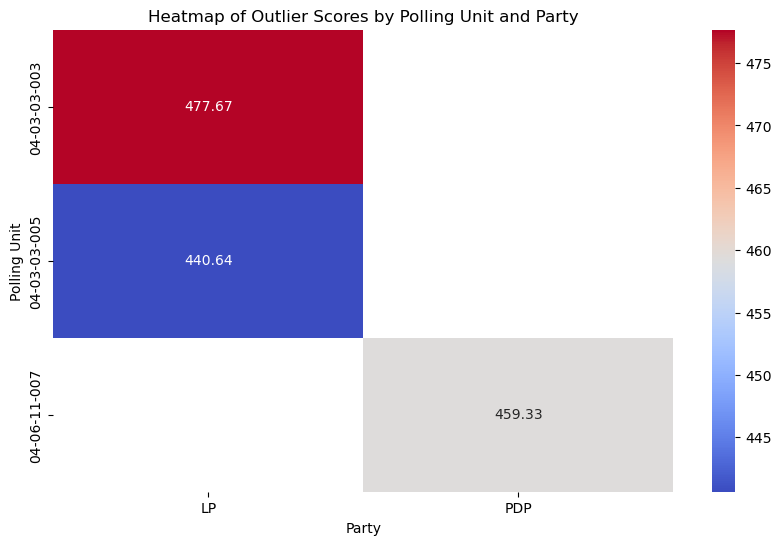

In [14]:
# Heatmap of Outlier Scores
pivot_df = df.pivot("PU-Code", "Party", "Outlier_Score")
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_df, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Heatmap of Outlier Scores by Polling Unit and Party')
plt.xlabel('Party')
plt.ylabel('Polling Unit')
plt.show()

### Explanation of Visualizations:

#### Bar Plot:

The bar plot shows the outlier scores for each party in the top outlier polling units.
This visualization helps in comparing the outlier scores across different polling units and parties.

#### Scatter Plot:

The scatter plot shows the relationship between the votes and average votes of neighboring units.
The size of the points represents the outlier scores.
This visualization highlights the deviation of votes in the polling units compared to their neighbors.

#### Heatmap:

The heatmap shows the distribution of outlier scores across the polling units and parties.
This visualization provides a clear view of which polling units have the most significant deviations in votes for each party.
These visualizations will help in understanding the insights from the data and identifying the most significant outliers.

## Conclusion

Based on the analysis carried on the crosschecked election dataset for anambra state for 3679 polling unit. The geographic coordinates for 3614 of the polling units in the state were obtained from public sources. Thus, the polling units that had no latitude and longitude was dropped which made the remaining polling units as 3614.

Based on the analysis conducted the data was grouped by LGA and the distance between all the polling units within the LGA was determined and used to create neighboring polling unit that were at a distance of 1km or less for each polling unit. This result was further broken down based on the votes by the parties at the row level.

This result led to the creation of the average votes obtained from the neighboring polling unit and this figure when compared with the vote by each party in the polling unit was used to determine an outlier score computed based on the absolute difference between the party vote from the average vote of the neighboring polling unit for that party. This result was then sorted in descending order by the outlier score and the top 3 parties with the highest outlier score was used in sorting them.

Based on these results, the top three polling units with the highest outlier scores were 04-03-03-003, 04-06-11-007, 04-03-03-005 which represents AMA-ENUGU II in ANAMBRA EAST LGA (LP) with outlier score of 477.6666667, AMAMKPU V HALL in AWKA NORTH LGA (PDP) with outlier score of 459.3333333, AMA-OKPOGBA in ANAMBRA EAST LGA (LP) with outlier score of 440.6428571.
